Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
R² Score: 0.958
MAE: 9.444
RMSE: 17.201

Predicted Loan Amount (Lakhs) for unseen input: 84.14


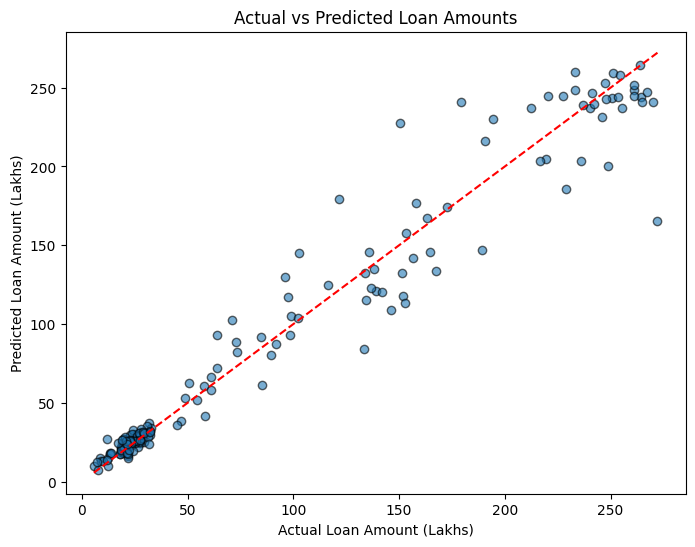

In [1]:
# ===============================================
# Step 1: Import Libraries
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# ===============================================
# Step 2: Load Dataset
# ===============================================

data = pd.read_csv("indian_loan_dataset_1000_rows.csv")

# Drop ID column
data = data.drop(columns=["ID"])

# ===============================================
# Step 3: Preprocessing
# ===============================================
X = data.drop(columns=["Loan_Amount_Lakhs"])
y = data["Loan_Amount_Lakhs"]

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# ===============================================
# Step 4: Train-Test Split
# ===============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ===============================================
# Step 5: XGBoost + RandomizedSearchCV
# ===============================================
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,   # Smaller for faster training
    cv=3,
    n_jobs=-1,
    scoring="r2",
    random_state=42,
    verbose=1,
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# ===============================================
# Step 6: Evaluation
# ===============================================
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best Parameters:", random_search.best_params_)
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# ===============================================
# Step 7: Test on Unseen Input
# ===============================================
unseen_input = pd.DataFrame({
    "Age": [35],
    "Income_Lakhs": [15],
    "Credit_Score": [720],
    "Marital_Status": ["Married"],
    "Purpose": ["Business"]
})

# Encode unseen input same as training data
unseen_encoded = pd.get_dummies(unseen_input)
unseen_encoded = unseen_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Scale unseen input
unseen_scaled = scaler.transform(unseen_encoded)

# Predict
unseen_pred = best_model.predict(unseen_scaled)[0]
print(f"\nPredicted Loan Amount (Lakhs) for unseen input: {unseen_pred:.2f}")

# ===============================================
# Step 8: Visualization
# ===============================================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Loan Amount (Lakhs)")
plt.ylabel("Predicted Loan Amount (Lakhs)")
plt.title("Actual vs Predicted Loan Amounts")
plt.show()


In [9]:
import pickle

# Save the trained model
with open("xgb_best_model.pkl", "wb") as f:
    pickle.dump((best_model, scaler, X_encoded.columns), f)

# Save the scaler
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

# Save the encoded column names (for unseen input alignment)
with open("columns.pkl", "wb") as col_file:
    pickle.dump(X_encoded.columns.tolist(), col_file)

print("✅ Model, Scaler, and Columns saved as pickle files.")

✅ Model, Scaler, and Columns saved as pickle files.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1000 non-null   int64  
 1   Income_Lakhs       1000 non-null   float64
 2   Credit_Score       1000 non-null   int64  
 3   Marital_Status     1000 non-null   object 
 4   Purpose            1000 non-null   object 
 5   Loan_Amount_Lakhs  1000 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 47.0+ KB


In [7]:
data.head()

,Age,Income_Lakhs,Credit_Score,Marital_Status,Purpose,Loan_Amount_Lakhs
0,22,16.2,695,Married,Business,76.8
1,39,13.3,690,Unmarried,Personal,14.4
2,39,9.3,777,Unmarried,Car,23.7
3,23,16.7,676,Married,Car,24.5
4,44,31.0,678,Unmarried,Education,32.2
